# Multi-Agent Plan Example

This notebook will show how to generate a plan POP from a multi-agent problem

## Setup the UP library (multiagent-fmap branch)

We start by installing the library with PIP

In [ ]:
# begin of installation

In [ ]:
!pip install --pre unified-planning[fmap]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.1/537.1 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 482.7/482.7 KB 27.2 MB/s eta 0:00:00


In [ ]:
# end of installation

Let's start by installing the library! The UP library can be installed directly from PIP with a single command.

## Creating the ma-depot problem

In [ ]:
from unified_planning.shortcuts import *
from unified_planning.model.multi_agent import *
from collections import namedtuple
from unified_planning.io.ma_pddl_writer import MAPDDLWriter

place = UserType("place")
locatable = UserType("locatable")
truck = UserType("truck", locatable)
hoist = UserType("hoist", locatable)
surface = UserType("surface", locatable)
pallet = UserType("pallet", surface)
crate = UserType("crate", surface)
pos = Fluent("pos", place=place)

at = Fluent("at", BoolType(), locatable=locatable, place=place)
on = Fluent("on", BoolType(), crate=crate, surface=surface)
In = Fluent("in", BoolType(), crate=crate, truck=truck)
clear = Fluent("clear", BoolType(), surface=surface)

available = Fluent("available", hoist=hoist)
lifting = Fluent("lifting", hoist=hoist, crate=crate)
driving = Fluent("driving", truck=truck)

drive = InstantaneousAction("drive", x=truck, y=place, z=place)
x = drive.parameter("x")
y = drive.parameter("y")
z = drive.parameter("z")

drive.add_precondition(pos(y))
drive.add_precondition(at(x, y))
drive.add_precondition(driving(x))
drive.add_effect(pos(z), True)
drive.add_effect(pos(y), False)
drive.add_effect(at(x, z), True)
drive.add_effect(at(x, y), False)

lift = InstantaneousAction("lift", p=place, x=hoist, y=crate, z=surface)
p = lift.parameter("p")
x = lift.parameter("x")
y = lift.parameter("y")
z = lift.parameter("z")

lift.add_precondition(pos(p))
lift.add_precondition(at(x, p))
lift.add_precondition(available(x))
lift.add_precondition(at(y, p))
lift.add_precondition(on(y, z))
lift.add_precondition(clear(y))

lift.add_effect(lifting(x, y), True)
lift.add_effect(clear(z), True)
lift.add_effect(at(y, p), False)
lift.add_effect(clear(y), False)
lift.add_effect(available(x), False)
lift.add_effect(on(y, z), False)

drop = InstantaneousAction("drop", p=place, x=hoist, y=crate, z=surface)
p = drop.parameter("p")
x = drop.parameter("x")
y = drop.parameter("y")
z = drop.parameter("z")

drop.add_precondition(pos(p))
drop.add_precondition(at(x, p))
drop.add_precondition(at(z, p))
drop.add_precondition(clear(z))
drop.add_precondition(lifting(x, y))

drop.add_effect(available(x), True)
drop.add_effect(at(y, p), True)
drop.add_effect(clear(y), True)
drop.add_effect(on(y, z), True)
drop.add_effect(lifting(x, y), False)
drop.add_effect(clear(z), False)

load = InstantaneousAction("load", p=place, x=hoist, y=crate, z=truck)
p = load.parameter("p")
x = load.parameter("x")
y = load.parameter("y")
z = load.parameter("z")

load.add_precondition(pos(p))
load.add_precondition(at(x, p))
load.add_precondition(at(z, p))
load.add_precondition(lifting(x, y))

load.add_effect(In(y, z), True)
load.add_effect(available(x), True)
load.add_effect(lifting(x, y), False)

unload = InstantaneousAction("unload", p=place, x=hoist, y=crate, z=truck)
p = unload.parameter("p")
x = unload.parameter("x")
y = unload.parameter("y")
z = unload.parameter("z")

unload.add_precondition(pos(p))
unload.add_precondition(at(x, p))
unload.add_precondition(at(z, p))
unload.add_precondition(available(x))
unload.add_precondition(In(y, z))

unload.add_effect(lifting(x, y), True)
unload.add_effect(In(y, z), False)
unload.add_effect(available(x), False)

problem = MultiAgentProblem("depot")

depot0_a = Agent("depot0_agent", problem)
distributor0_a = Agent("distributor0_agent", problem)
distributor1_a = Agent("distributor1_agent", problem)
driver0_a = Agent("driver0_agent", problem)
driver1_a = Agent("driver1_agent", problem)

driver0_a.add_action(drive)
driver1_a.add_action(drive)

depot0_a.add_action(lift)
depot0_a.add_action(drop)
depot0_a.add_action(load)
depot0_a.add_action(unload)

distributor0_a.add_action(lift)
distributor0_a.add_action(drop)
distributor0_a.add_action(load)
distributor0_a.add_action(unload)

distributor1_a.add_action(lift)
distributor1_a.add_action(drop)
distributor1_a.add_action(load)
distributor1_a.add_action(unload)

problem.ma_environment.add_fluent(at, default_initial_value=False)
problem.ma_environment.add_fluent(on, default_initial_value=False)
problem.ma_environment.add_fluent(In, default_initial_value=False)
problem.ma_environment.add_fluent(clear, default_initial_value=False)
depot0_a.add_private_fluent(lifting, default_initial_value=False)
depot0_a.add_private_fluent(available, default_initial_value=False)

distributor0_a.add_private_fluent(lifting, default_initial_value=False)
distributor0_a.add_private_fluent(available, default_initial_value=False)

distributor1_a.add_private_fluent(lifting, default_initial_value=False)
distributor1_a.add_private_fluent(available, default_initial_value=False)

driver0_a.add_private_fluent(driving, default_initial_value=False)
driver1_a.add_private_fluent(driving, default_initial_value=False)

depot0_a.add_public_fluent(pos, default_initial_value=False)
distributor0_a.add_public_fluent(pos, default_initial_value=False)
distributor1_a.add_public_fluent(pos, default_initial_value=False)
driver0_a.add_public_fluent(pos, default_initial_value=False)
driver1_a.add_public_fluent(pos, default_initial_value=False)

problem.add_agent(depot0_a)
problem.add_agent(distributor0_a)
problem.add_agent(distributor1_a)
problem.add_agent(driver0_a)
problem.add_agent(driver1_a)

truck0 = Object("truck0", truck)
truck1 = Object("truck1", truck)
depot0_place = Object("depot0_place", place)
distributor0_place = Object("distributor0_place", place)
distributor1_place = Object("distributor1_place", place)
crate0 = Object("crate0", crate)
crate1 = Object("crate1", crate)
pallet0 = Object("pallet0", pallet)
pallet1 = Object("pallet1", pallet)
pallet2 = Object("pallet2", pallet)

hoist0 = Object("hoist0", hoist)
hoist1 = Object("hoist1", hoist)
hoist2 = Object("hoist2", hoist)


problem.add_object(crate0)
problem.add_object(crate1)
problem.add_object(truck0)
problem.add_object(truck1)
problem.add_object(depot0_place)
problem.add_object(distributor0_place)
problem.add_object(distributor1_place)
problem.add_object(pallet0)
problem.add_object(pallet1)
problem.add_object(pallet2)
problem.add_object(hoist0)
problem.add_object(hoist1)
problem.add_object(hoist2)


problem.set_initial_value(at(pallet0, depot0_place), True)
problem.set_initial_value(clear(crate1), True)
problem.set_initial_value(at(pallet1, distributor0_place), True)
problem.set_initial_value(clear(crate0), True)
problem.set_initial_value(at(pallet2, distributor1_place), True)
problem.set_initial_value(clear(pallet2), True)

problem.set_initial_value(at(truck0, distributor1_place), True)
problem.set_initial_value(at(truck1, depot0_place), True)
problem.set_initial_value(at(hoist0, depot0_place), True)
problem.set_initial_value(at(hoist1, distributor0_place), True)
problem.set_initial_value(at(hoist2, distributor1_place), True)
problem.set_initial_value(at(crate0, distributor0_place), True)
problem.set_initial_value(on(crate0, pallet1), True)
problem.set_initial_value(at(crate1, depot0_place), True)
problem.set_initial_value(on(crate1, pallet0), True)

problem.set_initial_value(
    Dot(driver0_a, pos(distributor1_place)), True
)  
problem.set_initial_value(Dot(driver1_a, pos(depot0_place)), True)
problem.set_initial_value(Dot(depot0_a, pos(depot0_place)), True)
problem.set_initial_value(Dot(depot0_a, available(hoist0)), True)
problem.set_initial_value(Dot(distributor0_a, available(hoist1)), True)
problem.set_initial_value(Dot(distributor1_a, available(hoist2)), True)

problem.set_initial_value(Dot(distributor0_a, pos(distributor0_place)), True)
problem.set_initial_value(Dot(distributor1_a, pos(distributor1_place)), True)

problem.set_initial_value(Dot(driver0_a, driving(truck0)), True)
problem.set_initial_value(Dot(driver1_a, driving(truck1)), True)

problem.add_goal(on(crate0, pallet2))
problem.add_goal(on(crate1, pallet1))

Depot domain explained: https://www.jair.org/index.php/jair/article/view/10351/24754

Derek Long and Maria Fox. 2003. The 3rd International Planning Competition:
Results and Analysis. J. Artif. Intell. Res. (JAIR) 20 (12 2003).

## Solving Multi-Agent Planning Problems

The most direct way to solve a planning problem is to select an available planning engine by name and use it to solve the problem. In the following we use fmap to solve the problem and print the plan.

In [ ]:
with OneshotPlanner(name='fmap') as planner:
    result = planner.solve(problem)
    if result.status == up.engines.PlanGenerationResultStatus.SOLVED_SATISFICING:
        print("FMAP returned: %s" % result.plan)
    else:
        print("No plan found.")

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-5-2c9a6b454985>`, you are using the following planning engine:
  * Engine name: FMAP
  * Developers:  Alejandro Torreño, Oscar Sapena and Eva Onaindia
  * Description: FMAP: A Platform for the Development of Distributed Multi-Agent Planning Systems.

FMAP returned: DiGraph with 10 nodes and 10 edges


The unified_planning can also automatically select, among the available planners installed on the system, one that is expressive enough for the problem at hand.

The `all_sequential_plans()` method returns all possible `SequentialPlans` that respects the sorting constraints given by this `PartialOrderPlan`

We can also show all the possible `sequential plans` of this problem.

In [ ]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    print("%s returned Sequential Plans object: %s" % (planner.name, result.plan.all_sequential_plans()))
    [print(f"{idx} Sequential Plan: {seq_plan}") for idx, seq_plan in enumerate(result.plan.all_sequential_plans())]

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-6-55458cfe4bfa>`, you are using the following planning engine:
  * Engine name: FMAP
  * Developers:  Alejandro Torreño, Oscar Sapena and Eva Onaindia
  * Description: FMAP: A Platform for the Development of Distributed Multi-Agent Planning Systems.

FMAP returned Sequential Plans object: <generator object PartialOrderPlan.all_sequential_plans at 0x7f175e740c10>
0 Sequential Plan: [distributor0_agent.lift(distributor0_place, hoist1, crate0, pallet1), depot0_agent.lift(depot0_place, hoist0, crate1, pallet0), depot0_agent.load(depot0_place, hoist0, crate1, truck1), driver1_agent.drive(truck1, depot0_place, distributor0_place), distributor0_agent.load(distributor0_place, hoist1, crate0, truck1), distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1), driver1_agent.drive(truck1, distributor0_place, distributor1_place), distributor0_agent.drop(distributor0_place, hoist1, crate1, pallet1), di

Returns the graph of action instances as an adjacency list.

In [ ]:
print("Adjacency list:", result.plan.get_adjacency_list)

Adjacency list: {depot0_agent.lift(depot0_place, hoist0, crate1, pallet0): [depot0_agent.load(depot0_place, hoist0, crate1, truck1)], distributor0_agent.lift(distributor0_place, hoist1, crate0, pallet1): [depot0_agent.load(depot0_place, hoist0, crate1, truck1)], depot0_agent.load(depot0_place, hoist0, crate1, truck1): [driver1_agent.drive(truck1, depot0_place, distributor0_place)], driver1_agent.drive(truck1, depot0_place, distributor0_place): [distributor0_agent.load(distributor0_place, hoist1, crate0, truck1)], distributor0_agent.load(distributor0_place, hoist1, crate0, truck1): [distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)], distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1): [distributor0_agent.drop(distributor0_place, hoist1, crate1, pallet1), driver1_agent.drive(truck1, distributor0_place, distributor1_place)], distributor0_agent.drop(distributor0_place, hoist1, crate1, pallet1): [distributor1_agent.unload(distributor1_place, hoist2, cr

###Creating a POP graph

We can create an output file for the Graphviz tool

In [ ]:
print("Returned depot_graph: \n", result.plan.get_graph_file("depot_graph"))

Returned depot_graph: 
 digraph {
	"depot0_agent.lift(depot0_place, hoist0, crate1, pallet0)" -> "depot0_agent.load(depot0_place, hoist0, crate1, truck1)"
	"distributor0_agent.lift(distributor0_place, hoist1, crate0, pallet1)" -> "depot0_agent.load(depot0_place, hoist0, crate1, truck1)"
	"depot0_agent.load(depot0_place, hoist0, crate1, truck1)" -> "driver1_agent.drive(truck1, depot0_place, distributor0_place)"
	"driver1_agent.drive(truck1, depot0_place, distributor0_place)" -> "distributor0_agent.load(distributor0_place, hoist1, crate0, truck1)"
	"distributor0_agent.load(distributor0_place, hoist1, crate0, truck1)" -> "distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)"
	"distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)" -> "distributor0_agent.drop(distributor0_place, hoist1, crate1, pallet1)"
	"distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)" -> "driver1_agent.drive(truck1, distributor0_place, distributor1_place)"
	"distrib

We can use the Graphviz library to create the graph image from our depot_graph.dot

In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import graphviz
from IPython.display import Image

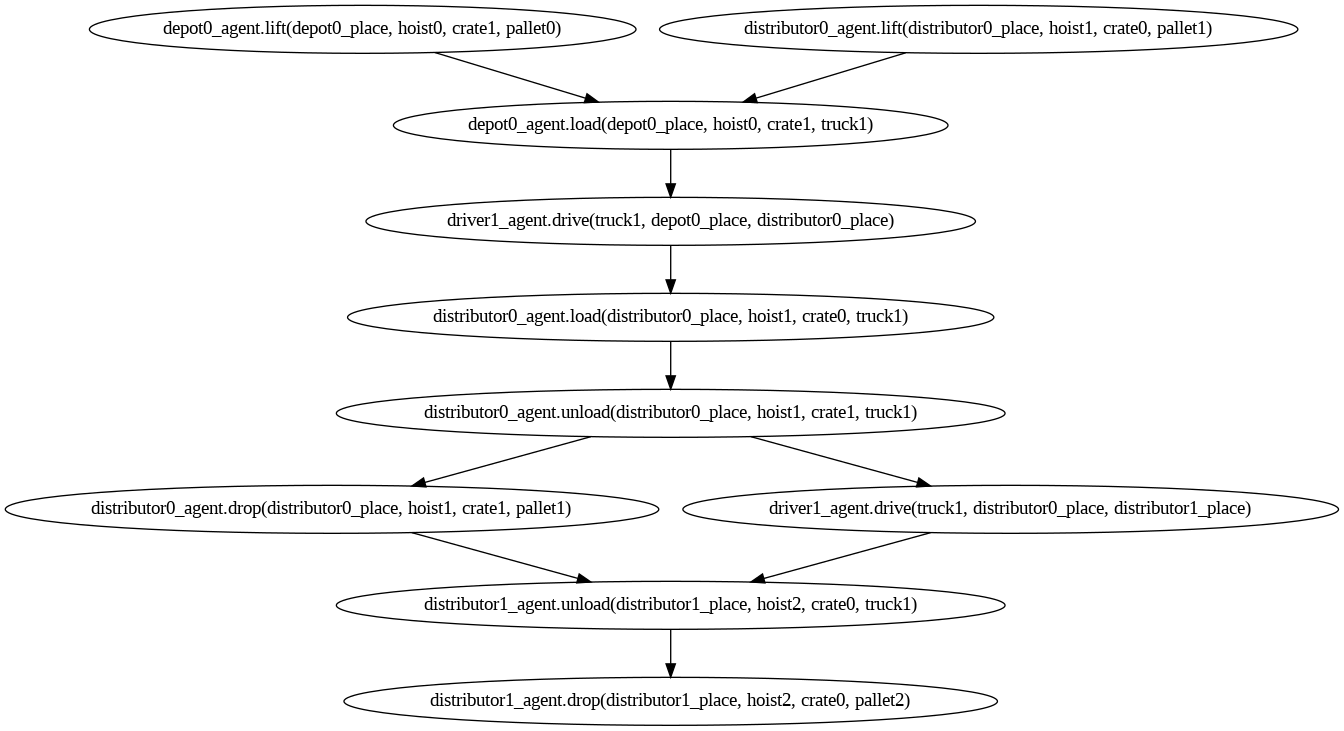

In [ ]:
graph = graphviz.Source.from_file('depot_graph.dot')
graph.render('graph', format='png')
Image(filename='graph.png')